# 1D harmonic oscillator using Physics-Informed Neural Network (PINN)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def oscillator(d,w0,x):
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    cos = torch.cos(phi + w*x)
    A = 1/(2*np.cos(phi))
    exp = torch.exp(-d*x)
    y = exp*2*A*cos
    return y

# Generate Data 

torch.Size([500, 1]) torch.Size([500, 1])


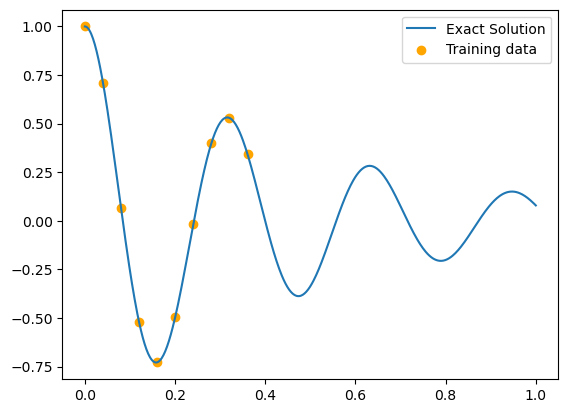

In [5]:
d, w0 = 2,20

#Analytic solution
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d,w0,x).view(-1,1)

# Slicing out small amount of training data
x_train = x[0:200:20]
y_train = y[0:200:20]
print(x.shape,y.shape)

plt.figure()
plt.plot(x,y,label='Exact Solution')
plt.scatter(x_train,y_train,color='orange',label='Training data')
plt.legend()
plt.show()

# Normal Neural Network
- First we train our data points in a normal neural network and see the results

In [19]:
# Before that let's create a function to plot our results to avoid code repetition
def plot_result(x,y,x_train,y_train,y_predicted,x_physics=None):
    plt.figure(figsize=(8,4))
    plt.plot(x,y,color="grey",linewidth=2,alpha=0.8,label='Exact Solution')
    plt.scatter(x_train,y_train,color='orange',label='Training Data')
    if x_physics is not None:
        plt.scatter(x_physics, 0*torch.ones_like(x_physics),alpha=0.4,color='green',label='Physics loss training locations')
        
    plt.plot(x,y_predicted,color='blue',label='Neural Network Prediction')
    plt.legend(loc=(1.01,0.34),frameon=False,fontsize="large")
    plt.xlim(-0.05,1.05)
    plt.ylim(-1.05,1.05)
    plt.text(1.05,0.7,f"Training step: {i+1}",fontsize="xx-large")
    plt.axis('off')

#Function to create a gif
from PIL import Image
def save_gif_PIL(outfile, files,fps=5,loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF',append_images=imgs[1:],save_all=True, duration=int(1000/fps),loop=0)

In [8]:
# Now creating a Fully connected neural network
class FCN(nn.Module):   # Inheriting from the base class of NN modules in PyTorch
    def __init__(self,input_size,hidden_size,output_size,layers):
        super().__init__() # Calls parent class's contructor to initialize inherited methods and attributes
        activation = nn.Tanh
        self.input_to_hidden = nn.Sequential(*[
                                    nn.Linear(input_size,hidden_size),
                                    activation()])
        
        self.hidden_to_hidden = nn.Sequential(*[
                                    nn.Sequential(*[
                                        nn.Linear(hidden_size,hidden_size),
                                        activation()]) for _ in range(layers-1)])
        self.hidden_to_output = nn.Sequential(*[
                                    nn.Linear(hidden_size,output_size),
                                    activation()])

    def forward(self,x):
        x = self.input_to_hidden(x)
        x = self.hidden_to_hidden(x)
        x = self.hidden_to_output(x)
        return x

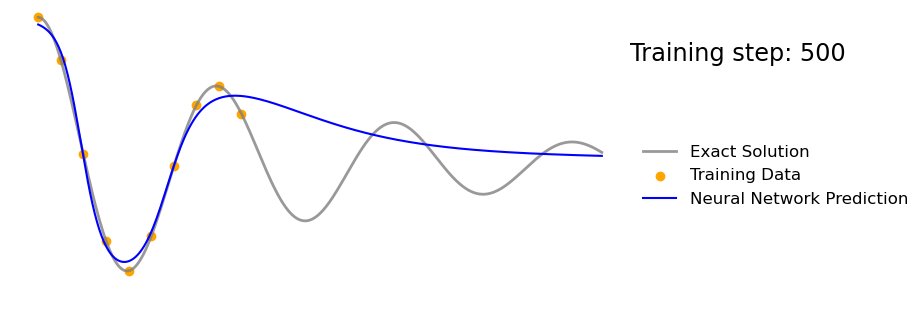

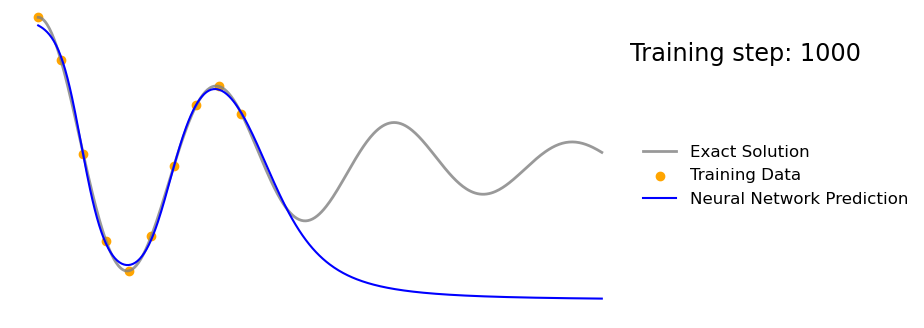

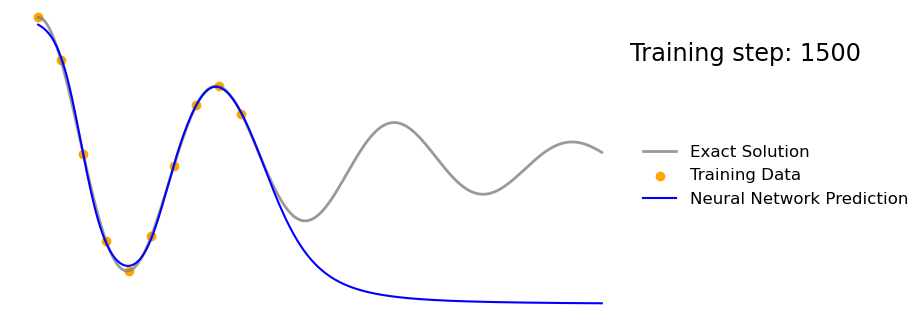

In [14]:
# Training standard neural network to fit the training data
model = FCN(1,32,1,3)  # input_size = 1 , hidden_layer_size = 32, output_size = 1, number_of_layers=3
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) # lr = learning rate, Adam optimizer of model parameters
files = []
for i in range(1500):
    optimizer.zero_grad()   # To reset the gradients
    y_predicted = model(x_train)   # To do a forward pass
    loss = torch.mean((y_predicted-y_train)**2)  # Using the mean squared error loss function
    loss.backward()  # Backward propagation to calculate gradients of loss with respect to each model paramter
    optimizer.step()  # Updates model parameters based on the gradients calculated during Back_Prop
    
    #Plotting the result as training progresses
    if (i+1)%10 == 0:

        y_predicted = model(x).detach()
        plot_result(x,y,x_train,y_train,y_predicted)
        file = "plots/nn_%i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor='white')
        files.append(file)

        if(i+1)%500 ==0: plt.show()
        else: plt.close('all')

save_gif_PIL('nn.gif',files,fps=20,loop=0)

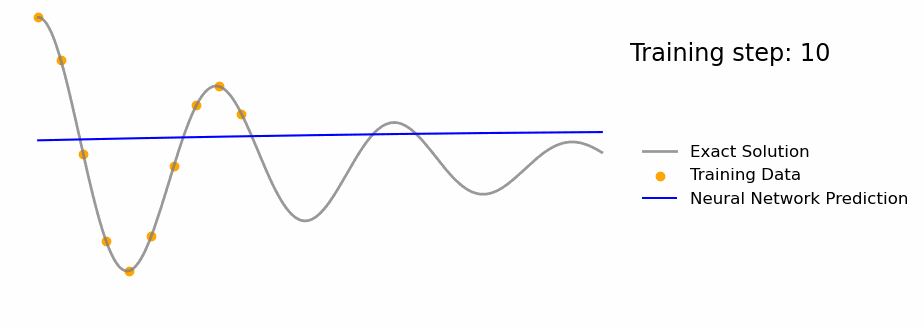

In [16]:
from IPython.display import Image

Image(filename='nn.gif')

# PINN
- As we can see that a Normal Neural Network struggles to generalises beyond the training data since it has limited amount of training data
- To "compensate" for the limited data , we provide it with "additional information" in means of PHYSICS LOSS
- We basically incorporate the underlying physics(which is nothing but a Differential Equation), in order to 'force' it to satisfy that Differential Equation

#### Evaluate physics loss at 30 points uniformly placed over the domain [0,1]. Calculate derivative of network's solution with respect to it's input variable at these points using PyTorch's autodifferentiation feature 

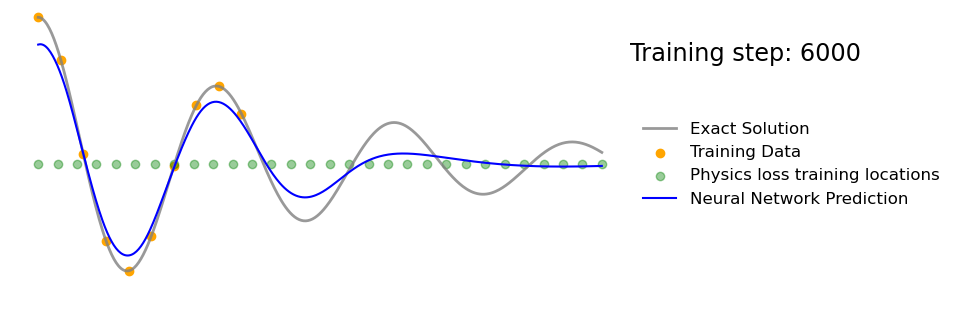

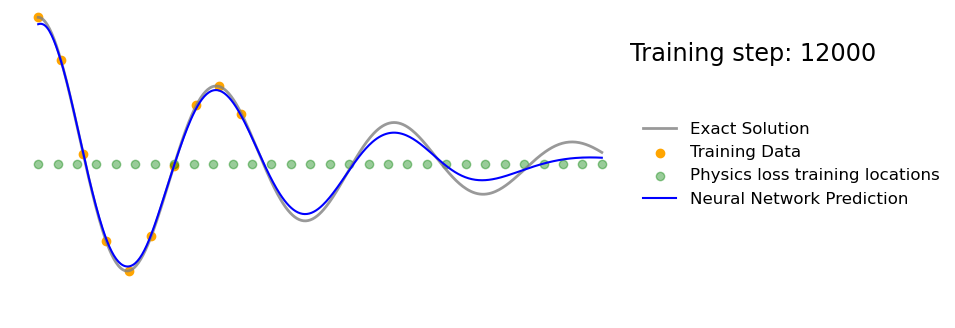

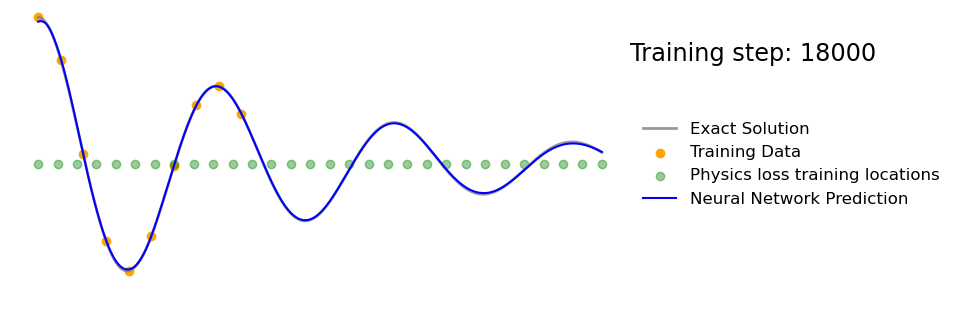

In [21]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)  #Sample locations over the problem domain
mu, k = 2*d, w0**2

model = FCN(1,32,1,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files= []
for i in range(20000):
    optimizer.zero_grad()

    #Compute data loss
    y_predicted = model(x_train) #Forward passa through the data
    loss1 = torch.mean((y_predicted-y_train)**2)  #Mean squared error

    #Compute the physics loss
    y_physics = model(x_physics)  #Forward pass through the sample locations to compute physics loss
    dy_dx = torch.autograd.grad(y_physics, x_physics, torch.ones_like(y_physics), create_graph =True)[0]  # Compute dy/dx
    dy2_dx2 = torch.autograd.grad(dy_dx, x_physics, torch.ones_like(dy_dx), create_graph=True)[0]  #Compute d^2y/dx^2 (second derivative of 'y' wrt 'x')
    physics = dy2_dx2 + mu*dy_dx + k*y_physics #Computes the residual of the Harmonic oscillator Differential Equation
    loss2 = (1e-4)*torch.mean(physics**2)

    #Backpropagate loss1 + loss2
    loss = loss1 + loss2 
    loss.backward()  #Backpropagation using combined loss
    optimizer.step()


    #Plotting the result 
    if (i+1)%150==0:

        y_predicted = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_train,y_train,y_predicted,xp)

        file = "plots/pinn_%i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor='white')
        files.append(file)

        if (i+1)%6000==0:
            plt.show()
        else:
            plt.close('all')

save_gif_PIL("pinn.gif",files,fps=20,loop=0)

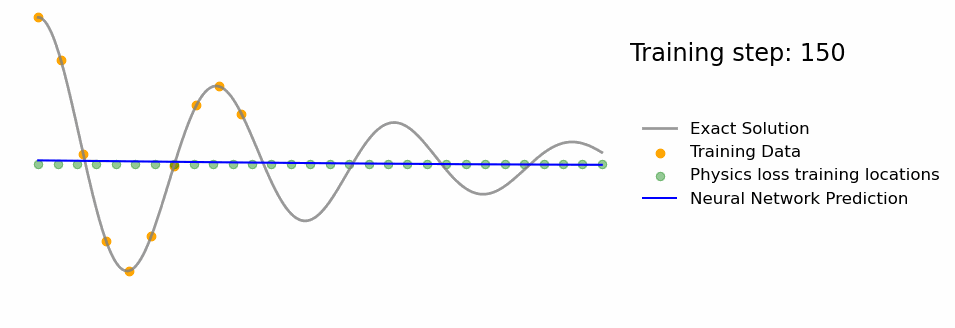

In [25]:
from IPython.display import Image
Image(filename='pinn.gif')

# Conclusion
- By incorporating the known physics of the system (differential equation of harmonic oscillator) we were able to train our neural network to generalise well beyond the range of our given training data 